In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf ssd
!mkdir ssd
!mkdir ssd/checkpoints
!mkdir ssd/checkpoints/soups
!mkdir results

In [ ]:
!pip install wget
!pip install clip
!pip install datasets
!pip install GPUtil pytorch_pretrained_bert transformers
!pip uninstall emoji
!pip install emoji==1.7

!pip install barbar

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8f6b3e43ee1f4627226610f82783ff8dc32e2816c4be94f00b5d42513e4cf40e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6988 sha256=0c1f6d54a8def80092606129788c6d0e3fdd81f7cd0ab1059c41300233472270
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... d

In [ ]:
from emoji import UNICODE_EMOJI
import wget
import clip
from transformers import AutoModel
from barbar import Bar
from transformers import AutoTokenizer, AutoModel

In [ ]:


import os

import torch

import os
import json
import operator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
import torch.nn as nn
import torch

import torch.nn.functional as F
from torch.autograd import Variable
import re
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [ ]:
dic = {
      "egypt": 'المصرية',
	  "nile": 'المصرية',
	  "msa": "اللغة العربية الفصحى",
	  "magreb": "المغربية",
	  "gulf": "الخليجية",
	  "levant": "الشامية"
}

In [ ]:

INITIAL_MODEL_RESULTS_FILE_H = 'initial_model_results_h.jsonl'
INITIAL_MODEL_RESULTS_FILE_T = 'initial_model_results_t.jsonl'


# RNN models

In [ ]:
class AttentionWithContext(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionWithContext, self).__init__()

        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.contx = nn.Linear(hidden_dim, 1, bias=False)
        #self.apply(init_weights)
    def forward(self, inp):
        u = torch.tanh_(self.attn(inp))
        a = F.softmax(self.contx(u), dim=1)
        s = (a * inp).sum(1)
        return s




In [ ]:



class ATTClassifier(nn.Module):
    def __init__(self, in_feature, class_num=1, dropout_prob=0.2):
        super(ATTClassifier, self).__init__()
        self.model =  AttentionWithContext(in_feature)

        self.Classifier = nn.Sequential(
            nn.Linear(2 * in_feature, 512),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(512, class_num)
        )

        self.apply(init_weights)

    def forward(self, x):

        mod = self.model(x[0]) #(X[0] (bs, seqlenght, embedD) att = \sum_i alpha_i x[0][i]
        xx = torch.cat([mod, x[1]], 1)

        out = self.Classifier(xx)
        return out


In [ ]:
ls

drive/  results/  sample_data/  ssd/


# utils

In [ ]:
def plot_cf(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
def calc_accuracy(preds,y):
    predict = torch.argmax(preds, dim=1)
    accuracy = torch.sum(predict == y.squeeze()).float().item()
    return accuracy / float(preds.size()[0])

In [ ]:
def assign_learning_rate(param_group, new_lr):
    param_group["lr"] = new_lr

In [ ]:
def _warmup_lr(base_lr, warmup_length, step):
    return base_lr * (step + 1) / warmup_length

In [ ]:
def cosine_lr(optimizer, base_lrs, warmup_length, steps):
    if not isinstance(base_lrs, list):
        base_lrs = [base_lrs for _ in optimizer.param_groups]
    assert len(base_lrs) == len(optimizer.param_groups)
    def _lr_adjuster(step):
        for param_group, base_lr in zip(optimizer.param_groups, base_lrs):
            if step < warmup_length:
                lr = _warmup_lr(base_lr, warmup_length, step)
            else:
                e = step - warmup_length
                es = steps - warmup_length
                lr = 0.5 * (1 + np.cos(np.pi * e / es)) * base_lr
            assign_learning_rate(param_group, lr)
    return _lr_adjuster

# main

In [ ]:


args = {"data_location": os.path.expanduser('./data'),
        "model_location": os.path.expanduser('./ssd/checkpoints/soups'),
        "download_models": False,
        "eval_individual_models":True,
        "uniform_soup": True,
        "greedy_soup": True,
        "plot": True,
        "batch_size": 36,
        "workers": 8,
        "pretrained_path": "UBC-NLP/MARBERT",
        'loss' : 'FL',
        'max_length': 64

}



In [ ]:
args

{'data_location': './data',
 'model_location': './ssd/checkpoints/soups',
 'download_models': False,
 'eval_individual_models': True,
 'uniform_soup': True,
 'greedy_soup': True,
 'plot': True,
 'batch_size': 36,
 'workers': 8,
 'pretrained_path': 'UBC-NLP/MARBERT',
 'loss': 'FL',
 'max_length': 64}

In [ ]:

args["model_location"]

'./ssd/checkpoints/soups'

In [ ]:
if not os.path.exists(args["model_location"]):
    os.mkdir(args["model_location"])

In [ ]:
ls ./ssd/checkpoints/soups

In [ ]:
model_paths_base = []


In [ ]:
model_paths_cls = []


In [ ]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:

class TransformerLayer(nn.Module):
    def __init__(self,both=True,
                pretrained_path='aubmindlab/bert-base-arabert'):
        super(TransformerLayer, self).__init__()

        self.both = both
        self.transformer = AutoModel.from_pretrained(pretrained_path, output_hidden_states=True)


    def forward(self, input_ids=None, attention_mask=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # (output_last_layer, pooled_cls, (output_layers))
        # output[0] (8, seqlen=64, 768) cls [8, 768] ( 12 (8, seqlen=64, 768))

        return outputs

    def output_num(self):
        return self.transformer.config.hidden_size




In [ ]:
def is_emoji(s):
    return s in UNICODE_EMOJI

In [ ]:
def add_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

In [ ]:
def preprocess(text, lang='ar'):
    sent = add_space(text)
    sent = re.sub(r'(?:@[\w_]+)', "user", sent)
    sent = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', "url", sent)
    sent = sent.replace('_', ' ')
    sent = sent.replace('#', ' ')
    return sent

def prepare_text(df, col='tweet'):
    if col == 'tweet':
        df['dialect'] = df['dialect'].map(dic)
    for i in range(df.shape[0]):
        df.loc[i, col] = df.loc[i, 'dialect'] + ' [SEP] ' + df.loc[i, col]


    return df

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, pretraine_path='xlm-roberta-base', max_length=128):
        self.df = df
        self.max_length = max_length

        self.tokenizer = AutoTokenizer.from_pretrained(pretraine_path)

    def __getitem__(self, index):
        text = self.df.iloc[index]['tweet']
        label = self.df.iloc[index]["sarcastic"]
        #print("label", label)

        encoded_input = self.tokenizer(
                text,
                max_length = self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt",
            )

        input_ids = encoded_input["input_ids"]
        attention_mask = encoded_input["attention_mask"] if "attention_mask" in encoded_input else None

        data_input = {
            "input_ids":input_ids.flatten(),
            "attention_mask": attention_mask.flatten()
        }

        label_input ={
            "sarcasm": torch.tensor(label, dtype=torch.float),
        }

        return data_input, label_input

    def __len__(self):
        return self.df.shape[0]

In [ ]:
def loadValData(batchsize=16, num_worker=2, pretraine_path="xlm-roberta-base", max_length=128):
    path = "/content/drive/MyDrive/iSarcasm/Datasets2/split_80_20/val.csv"
    data = pd.read_csv(path, encoding='utf-8')
    data['tweet'] = data['tweet'].apply(lambda x:preprocess(x))
    print(data.shape)
    print(data.head())

    data = prepare_text(data, col='tweet')

    DF_test = TrainDataset(data, pretraine_path, max_length)

    DF_test_loader = DataLoader(dataset=DF_test, batch_size=batchsize, shuffle=False,
                                num_workers=num_worker)
    return DF_test_loader



In [ ]:
def loadTestData(batchsize=16, num_worker=2, pretraine_path="xlm-roberta-base", max_length=128):
    path = "/content/drive/MyDrive/iSarcasm/Datasets2/tweet/task_A_Ar_test.csv"
    data = pd.read_csv(path, encoding='utf-8')
    data['tweet'] = data['tweet'].apply(lambda x:preprocess(x))
    data = prepare_text(data, col='tweet')

    DF_test = TrainDataset(data, pretraine_path, max_length)

    DF_test_loader = DataLoader(dataset=DF_test, batch_size=batchsize, shuffle=False,
                                num_workers=num_worker)


    return DF_test_loader



In [ ]:
def loadExamplesData(batchsize=16, num_worker=2, pretraine_path="xlm-roberta-base", max_length=128):
    path = "/content/drive/MyDrive/iSarcasm/Datasets2/tweet/examples.csv"
    data = pd.read_csv(path, encoding='utf-8')
    data['tweet'] = data['tweet'].apply(lambda x:preprocess(x))
    data = prepare_text(data, col='tweet')

    DF_test = TrainDataset(data, pretraine_path, max_length)

    DF_test_loader = DataLoader(dataset=DF_test, batch_size=batchsize, shuffle=False,
                                num_workers=num_worker)


    return DF_test_loader



In [ ]:
def predict(base_model, mt_classifier, iterator):
    # initialize every epoch
    acc_sarcasm= 0
    loss_sarc= 0

    f1_sarcasm =0
    f1_score_macro = 0

    #all_sarcasm_outputs = []
    all_sarcasm_outputs = np.array([])
    all_sarcasm_labels = np.array([])

    # set the model in eval phase
    base_model.eval()
    mt_classifier.eval()
    with torch.no_grad():
      for data_input, label_input in Bar(iterator):
            for k, v in data_input.items():
                data_input[k] = v.to(device)

            for k, v in label_input.items():
                label_input[k] = v.long().to(device)

            sarcasm_target = label_input['sarcasm']

            # forward pass

            output = base_model(**data_input)
            sarcasm_logits = mt_classifier(output)
            logits = sarcasm_logits[:,:2]

            sarcasm_probs = torch.softmax(logits, dim=1)
            # compute the loss
            acc_sarcasm += calc_accuracy(sarcasm_probs, sarcasm_target)

            _, predicted_sarcasm = torch.max(sarcasm_probs, 1)
            all_sarcasm_outputs = np.append(all_sarcasm_outputs, predicted_sarcasm.squeeze().cpu().numpy())
            all_sarcasm_labels = np.append(all_sarcasm_labels, sarcasm_target.squeeze().cpu().numpy())

    all_sarcasm_outputs = all_sarcasm_outputs.reshape(-1)
    all_sarcasm_labels = all_sarcasm_labels.reshape(-1)

    fscore_macro = f1_score(y_true=all_sarcasm_labels, y_pred=all_sarcasm_outputs, average='macro')
    fscore_sarcasm = f1_score(all_sarcasm_labels, all_sarcasm_outputs, average='binary', pos_label=1)


    report_sarcasm = classification_report(y_true=all_sarcasm_labels, y_pred=all_sarcasm_outputs,digits=4)


    accuracies = { 'accuracy': acc_sarcasm / len(iterator), 'f1_sarcastic': fscore_sarcasm, "f1_score": fscore_macro, 'report_sarcasm': report_sarcasm}
    return accuracies, all_sarcasm_outputs, all_sarcasm_labels


In [ ]:
def eval_full(config, loader1, base_model, classifier):
    criterion = config['loss']
    df = pd.DataFrame()
    accuracies, all_outputs_pred, all_outputs_label = predict(base_model, classifier, loader1)
    return accuracies, all_outputs_pred, all_outputs_label


In [ ]:
def get_model_from_sd( base_model):
    classifier = ATTClassifier(base_model.output_num(), class_num=2).to(device)
    classifier.parameters()
    for p in classifier.parameters():
            p.data = p.data.float()
    classifier = classifier.cuda()
    devices = [x for x in range(torch.cuda.device_count())]
    return torch.nn.DataParallel(classifier,  device_ids=devices)

In [ ]:
val_loader = loadValData(batchsize=args['batch_size'], num_worker=0, pretraine_path=args['pretrained_path'], max_length=args['max_length'])

(621, 6)
   Unnamed: 0    id                                              tweet  \
0         898  2949  كل يوم يافيفي تثبتي انك تستحقي لقب الام المثال...   
1         624   673                       والله دي عزومة مراكبية كثيير   
2        1062   268                           هالشب أطول من يوم الجمعة   
3        1862    36         الباب الي يجيلك منه الريح شيله وركب قبنوري   
4         663   632  هوه حد هيعد وراكو الورق ورقنا والدفاتر دفترنا ...   

   sarcastic                                    rephrase dialect  
0          0                                         NaN    nile  
1          1  والله انت بتعرض خدماتك بالقول بس مش بالفعل    nile  
2          1                                   الشب طويل  levant  
3          1               الي يعملك مشاكل شيله من حياتك    nile  
4          1          ارقام لا مصداقية لها وبيانات زائفة    nile  


In [ ]:
test_loader = loadTestData(batchsize=args['batch_size'], num_worker=0, pretraine_path=args['pretrained_path'],  max_length=args['max_length'])


In [ ]:
ls

drive/  results/  sample_data/  ssd/


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
TOTAL_MODELS = 16

In [ ]:
if os.path.exists(INITIAL_MODEL_RESULTS_FILE_H):
    os.remove(INITIAL_MODEL_RESULTS_FILE_H)

if os.path.exists(INITIAL_MODEL_RESULTS_FILE_T):
    os.remove(INITIAL_MODEL_RESULTS_FILE_T)

In [ ]:
base_model = TransformerLayer(pretrained_path=args['pretrained_path'], both=True).to(device)

In [ ]:
classifier = get_model_from_sd(base_model)

base_model = base_model.to(device)
classifier = classifier.to(device)

In [ ]:
results = {'model_name' : f'initial_model_h'}

val_accuracies,val_outputs, val_labels = eval_full(args, val_loader,  base_model, classifier )

621/621: [==============================>.] - ETA 5.9s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results['f1_sarcastic'] = val_accuracies['f1_sarcastic']
results['f1_score'] = val_accuracies['f1_score']

In [ ]:
with open(INITIAL_MODEL_RESULTS_FILE_H, 'a+') as f:
    f.write(json.dumps(results) + '\n')

In [ ]:



results = {'model_name' : f'initial_model_t'}

test_accuracies,test_outputs, test_labels = eval_full(args, test_loader,  base_model, classifier )

results['f1_sarcastic'] = test_accuracies['f1_sarcastic']
results['f1_score'] = test_accuracies['f1_score']


with open(INITIAL_MODEL_RESULTS_FILE_T, 'a+') as f:
    f.write(json.dumps(results) + '\n')
# uniform_soup_model_db_t = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_T, lines=True)
# print(uniform_soup_model_db_t)



1400/1400: [===============================>] - ETA 0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
initial_model_db_h = pd.read_json(INITIAL_MODEL_RESULTS_FILE_H, lines=True)
initial_model_db_h

,model_name,f1_sarcastic,f1_score
0,initial_model_h,0.387013,0.193506


In [ ]:
initial_model_db_t = pd.read_json(INITIAL_MODEL_RESULTS_FILE_T, lines=True)
initial_model_db_t

,model_name,f1_sarcastic,f1_score
0,initial_model_t,0.25,0.125


In [ ]:
%cp initial_model_results_h.jsonl '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/'
%cp initial_model_results_t.jsonl '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/'

In [ ]:
%cp figure_attn_t2.png  '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/'

In [ ]:
ls '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/'

best_model_f_all.jsonl          results_h11.jsonl  results_h6.jsonl   results_t1.jsonl
ensemble_model_results_t.jsonl  results_h12.jsonl  results_h7.jsonl   results_t2.jsonl
figure_attn_h2.png              results_h13.jsonl  results_h8.jsonl   results_t3.jsonl
figure_attn_h.png               results_h14.jsonl  results_h9.jsonl   results_t4.jsonl
figure_attn_t.png               results_h15.jsonl  results_t10.jsonl  results_t5.jsonl
figure_n_models_attn_t.png      results_h16.jsonl  results_t11.jsonl  results_t6.jsonl
greedy_soup_results_h.jsonl     results_h1.jsonl   results_t12.jsonl  results_t7.jsonl
greedy_soup_results_t.jsonl     results_h2.jsonl   results_t13.jsonl  results_t8.jsonl
initial_model_results_h.jsonl   results_h3.jsonl   results_t14.jsonl  results_t9.jsonl
initial_model_results_t.jsonl   results_h4.jsonl   results_t15.jsonl  uniform_soup_results_h.jsonl
results_h10.jsonl               results_h5.jsonl   results_t16.jsonl  uniform_soup_results_t.jsonl


In [ ]:

UNIFORM_SOUP_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/uniform_soup_results_h.jsonl'
UNIFORM_SOUP_RESULTS_FILE_T = '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/uniform_soup_results_t.jsonl'

GREEDY_SOUP_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/greedy_soup_results_h.jsonl'
GREEDY_SOUP_RESULTS_FILE_T = '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/greedy_soup_results_t.jsonl'
BEST_MODEL_RESULTS_FILE_T =  '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/best_model_f_all.jsonl'

In [ ]:
INDIVIDUAL_MODEL_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/results_h'+str(TOTAL_MODELS)+'.jsonl'



In [ ]:
individual_model_db_h = pd.read_json(INDIVIDUAL_MODEL_RESULTS_FILE_H, lines=True)
print(individual_model_db_h)

           model_name loss_fn  batch_size       lr  f1_sarcastic  f1_score  \
0   32_FL_2e-05_2_298      FL          32  0.00002      0.716535  0.821830   
1   64_FL_1e-05_2_298      FL          64  0.00001      0.611354  0.761748   
2   16_FL_2e-05_4_298      FL          16  0.00002      0.735632  0.832648   
3   36_FL_1e-05_2_298      FL          36  0.00001      0.714286  0.820779   
4   32_FL_1e-05_2_298      FL          32  0.00001      0.720000  0.824718   
5   36_FL_2e-05_2_298      FL          36  0.00002      0.728682  0.828772   
6   64_FL_2e-05_2_298      FL          64  0.00002      0.711462  0.818825   
7   32_FL_1e-05_4_298      FL          32  0.00001      0.714859  0.821679   
8   16_FL_2e-05_2_298      FL          16  0.00002      0.728682  0.828772   
9   32_FL_2e-05_4_298      FL          32  0.00002      0.726562  0.827784   
10  36_FL_2e-05_4_298      FL          36  0.00002      0.736434  0.833664   
11  64_FL_1e-05_4_298      FL          64  0.00001      0.725869

In [ ]:
ls '/content/drive/MyDrive/iSarcasm/attn/m_298/results'

best_model_f.jsonl  results_h.jsonl  results_t.jsonl


In [ ]:
uniform_soup_model_db_h = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_H, lines=True)
uniform_soup_model_db_h

,model_name,f1_sarcastic,f1_score,total_models,all_models_name
0,uniform_soup_h,0.725869,0.826820,1,64_FL_1e-05_4_298
1,uniform_soup_h,0.722222,0.825758,2,"36_FL_2e-05_4_298, 32_FL_1e-05_2_298"
2,uniform_soup_h,0.732283,0.831729,3,"36_FL_2e-05_2_298, 36_FL_1e-05_4_298, 36_FL_2e..."
3,uniform_soup_h,0.669492,0.795978,4,"64_FL_1e-05_4_298, 32_FL_2e-05_4_298, 32_FL_1e..."
4,uniform_soup_h,0.736434,0.833664,5,"36_FL_1e-05_2_298, 32_FL_1e-05_4_298, 36_FL_2e..."
5,uniform_soup_h,0.732283,0.831729,6,"16_FL_1e-05_4_298, 64_FL_2e-05_4_298, 36_FL_2e..."
6,uniform_soup_h,0.712551,0.820597,7,"36_FL_1e-05_4_298, 32_FL_1e-05_4_298, 16_FL_2e..."
7,uniform_soup_h,0.709163,0.817750,8,"32_FL_1e-05_4_298, 32_FL_2e-05_2_298, 36_FL_1e..."
8,uniform_soup_h,0.702479,0.815240,9,"36_FL_1e-05_2_298, 32_FL_1e-05_2_298, 36_FL_2e..."
9,uniform_soup_h,0.694215,0.810107,10,"16_FL_1e-05_4_298, 64_FL_2e-05_2_298, 16_FL_2e..."


In [ ]:
uniform_soup_model_db_t = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_T, lines=True)
uniform_soup_model_db_t

,model_name,f1_sarcastic,f1_score,total_models,all_models_name
0,uniform_soup_t,0.673317,0.809355,1,64_FL_1e-05_4_298
1,uniform_soup_t,0.682171,0.815598,2,"36_FL_2e-05_4_298, 32_FL_1e-05_2_298"
2,uniform_soup_t,0.692112,0.820921,3,"36_FL_2e-05_2_298, 36_FL_1e-05_4_298, 36_FL_2e..."
3,uniform_soup_t,0.650746,0.801641,4,"64_FL_1e-05_4_298, 32_FL_2e-05_4_298, 32_FL_1e..."
4,uniform_soup_t,0.695876,0.823477,5,"36_FL_1e-05_2_298, 32_FL_1e-05_4_298, 36_FL_2e..."
5,uniform_soup_t,0.681818,0.814703,6,"16_FL_1e-05_4_298, 64_FL_2e-05_4_298, 36_FL_2e..."
6,uniform_soup_t,0.702128,0.827962,7,"36_FL_1e-05_4_298, 32_FL_1e-05_4_298, 16_FL_2e..."
7,uniform_soup_t,0.698413,0.825672,8,"32_FL_1e-05_4_298, 32_FL_2e-05_2_298, 36_FL_1e..."
8,uniform_soup_t,0.674419,0.814408,9,"36_FL_1e-05_2_298, 32_FL_1e-05_2_298, 36_FL_2e..."
9,uniform_soup_t,0.683761,0.819218,10,"16_FL_1e-05_4_298, 64_FL_2e-05_2_298, 16_FL_2e..."


In [ ]:
greedy_soup_model_db_h = pd.read_json(GREEDY_SOUP_RESULTS_FILE_H, lines=True)
greedy_soup_model_db_h

,model_name,f1_sarcastic,f1_score,num_models,models,total_models,all_models_name
0,greedy_soup_h,0.725869,0.826820,1,64_FL_1e-05_4_298,1,64_FL_1e-05_4_298
1,greedy_soup_h,0.736434,0.833664,1,36_FL_2e-05_4_298,2,"36_FL_2e-05_4_298, 32_FL_1e-05_2_298"
2,greedy_soup_h,0.745098,0.839621,2,"36_FL_2e-05_4_298, 36_FL_1e-05_4_298",3,"36_FL_2e-05_2_298, 36_FL_1e-05_4_298, 36_FL_2e..."
3,greedy_soup_h,0.735178,0.833716,1,"36_FL_1e-05_4_298, 32_FL_1e-05_4_298",4,"64_FL_1e-05_4_298, 32_FL_2e-05_4_298, 32_FL_1e..."
4,greedy_soup_h,0.745098,0.839621,2,"36_FL_2e-05_4_298, 36_FL_1e-05_4_298",5,"36_FL_1e-05_2_298, 32_FL_1e-05_4_298, 36_FL_2e..."
5,greedy_soup_h,0.753846,0.844337,1,"16_FL_1e-05_4_298, 16_FL_2e-05_2_298",6,"16_FL_1e-05_4_298, 64_FL_2e-05_4_298, 36_FL_2e..."
6,greedy_soup_h,0.735632,0.832648,1,16_FL_2e-05_4_298,7,"36_FL_1e-05_4_298, 32_FL_1e-05_4_298, 16_FL_2e..."
7,greedy_soup_h,0.746154,0.839472,2,"16_FL_1e-05_4_298, 32_FL_2e-05_2_298",8,"32_FL_1e-05_4_298, 32_FL_2e-05_2_298, 36_FL_1e..."
8,greedy_soup_h,0.745098,0.839621,2,"36_FL_2e-05_4_298, 36_FL_1e-05_4_298",9,"36_FL_1e-05_2_298, 32_FL_1e-05_2_298, 36_FL_2e..."
9,greedy_soup_h,0.759398,0.846912,2,"16_FL_1e-05_4_298, 16_FL_2e-05_2_298, 64_FL_2e...",10,"16_FL_1e-05_4_298, 64_FL_2e-05_2_298, 16_FL_2e..."


'36_FL_1e-05_4_298, 32_FL_1e-05_4_298, 16_FL_2e-05_4_298, 16_FL_2e-05_2_298, 36_FL_2e-05_2_298, 32_FL_2e-05_2_298, 36_FL_1e-05_2_298'

In [ ]:
greedy_soup_model_db_t = pd.read_json(GREEDY_SOUP_RESULTS_FILE_T, lines=True)
greedy_soup_model_db_t

,model_name,f1_sarcastic,f1_score,num_models,models,total_models,all_models_name
0,greedy_soup_t,0.673317,0.809355,1,64_FL_1e-05_4_298,1,64_FL_1e-05_4_298
1,greedy_soup_t,0.655502,0.797524,1,36_FL_2e-05_4_298,2,"36_FL_2e-05_4_298, 32_FL_1e-05_2_298"
2,greedy_soup_t,0.668342,0.806694,2,"36_FL_2e-05_4_298, 36_FL_1e-05_4_298",3,"36_FL_2e-05_2_298, 36_FL_1e-05_4_298, 36_FL_2e..."
3,greedy_soup_t,0.678571,0.813123,1,"36_FL_1e-05_4_298, 32_FL_1e-05_4_298",4,"64_FL_1e-05_4_298, 32_FL_2e-05_4_298, 32_FL_1e..."
4,greedy_soup_t,0.668342,0.806694,2,"36_FL_2e-05_4_298, 36_FL_1e-05_4_298",5,"36_FL_1e-05_2_298, 32_FL_1e-05_4_298, 36_FL_2e..."
5,greedy_soup_t,0.663415,0.802837,1,"16_FL_1e-05_4_298, 16_FL_2e-05_2_298",6,"16_FL_1e-05_4_298, 64_FL_2e-05_4_298, 36_FL_2e..."
6,greedy_soup_t,0.608889,0.766998,1,16_FL_2e-05_4_298,7,"36_FL_1e-05_4_298, 32_FL_1e-05_4_298, 16_FL_2e..."
7,greedy_soup_t,0.686275,0.816381,2,"16_FL_1e-05_4_298, 32_FL_2e-05_2_298",8,"32_FL_1e-05_4_298, 32_FL_2e-05_2_298, 36_FL_1e..."
8,greedy_soup_t,0.668342,0.806694,2,"36_FL_2e-05_4_298, 36_FL_1e-05_4_298",9,"36_FL_1e-05_2_298, 32_FL_1e-05_2_298, 36_FL_2e..."
9,greedy_soup_t,0.674877,0.809870,2,"16_FL_1e-05_4_298, 16_FL_2e-05_2_298, 64_FL_2e...",10,"16_FL_1e-05_4_298, 64_FL_2e-05_2_298, 16_FL_2e..."


In [ ]:
greedy_soup_model_db_t['all_models_name'][6]

'36_FL_1e-05_4_298, 32_FL_1e-05_4_298, 16_FL_2e-05_4_298, 16_FL_2e-05_2_298, 36_FL_2e-05_2_298, 32_FL_2e-05_2_298, 36_FL_1e-05_2_298'

In [ ]:
best_model_db_h = pd.read_json(BEST_MODEL_RESULTS_FILE_T, lines=True)
# print("best_model_db_h", best_model_db_h)

In [ ]:
# array = [i+1 for i in range(len(uniform_soup_model_db_t))]

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


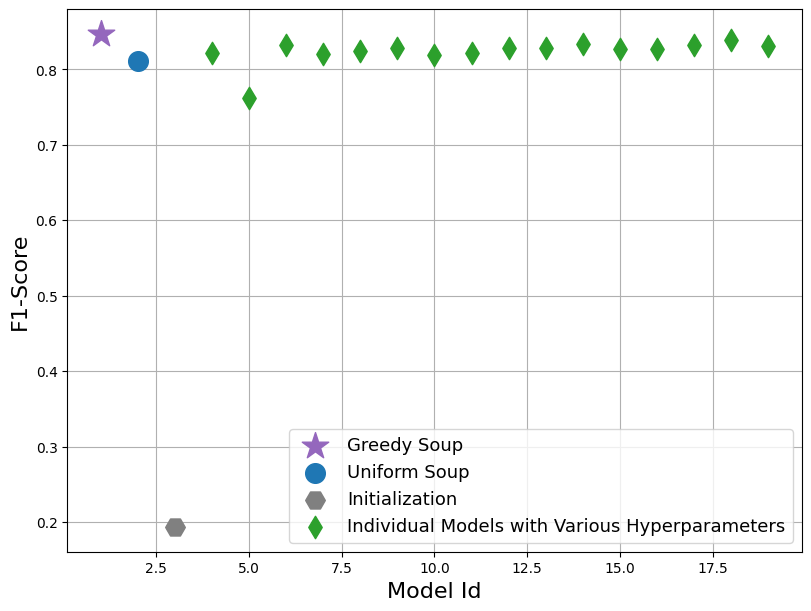

In [ ]:

# Step 5: Plot.

array=[]
array = [i+4 for i in range(TOTAL_MODELS)]
print(array)
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
ax = fig.subplots()

ax.scatter(
    1,
    greedy_soup_model_db_h['f1_score'][TOTAL_MODELS-1],
    marker='*',
    color='C4',
    s=400,
    label='Greedy Soup',
    zorder=10
)

ax.scatter(
    2,
    uniform_soup_model_db_h['f1_score'][TOTAL_MODELS-1],
    marker='o',
    color='C0',
    s=200,
    label='Uniform Soup',
    zorder=10
)
ax.scatter(
    3,
    initial_model_db_h['f1_score'],
    marker='H',
    color='Grey',
    s=200,
    label='Initialization',
    zorder=10
)


ax.scatter(
    array,
    individual_model_db_h['f1_score'].values,
    marker='d',
    color='C2',
    s=130,
    label='Individual Models with Various Hyperparameters',
    zorder=10
)

ax.set_ylabel('F1-Score', fontsize=16)
ax.set_xlabel('Model Id', fontsize=16)
ax.grid()
ax.legend(fontsize=13)
plt.savefig('figure_attn_h2.png', bbox_inches='tight')

In [ ]:
%cp figure_attn_h2.png /content/drive/MyDrive/iSarcasm/attn/m_298/results_i

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


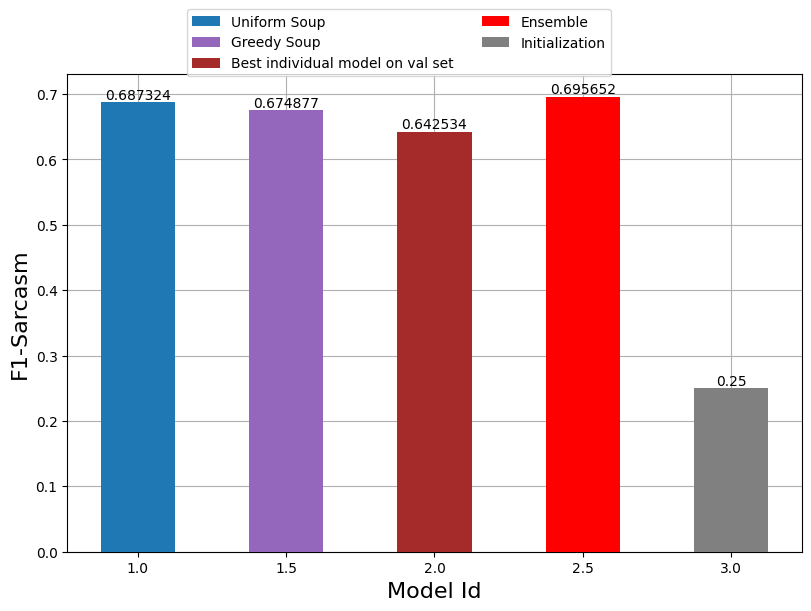

In [ ]:

UNIFORM_SOUP_RESULTS_FILE_T = '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/uniform_soup_results_t.jsonl'
GREEDY_SOUP_RESULTS_FILE_T = '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/greedy_soup_results_t.jsonl'
BEST_MODEL_RESULTS_FILE_T =  '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/best_model_f_all.jsonl'

ENSEMBLE_MODEL_RESULTS_FILE_T =  '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/ensemble_model_results_t.jsonl'
INITIAL_MODEL_RESULTS_FILE_T = '/content/drive/MyDrive/iSarcasm/attn/m_298/results_i/initial_model_results_t.jsonl'

initial_model_db_t = pd.read_json(INITIAL_MODEL_RESULTS_FILE_T, lines=True)

uniform_soup_model_db_t = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_T, lines=True)

greedy_soup_model_db_t = pd.read_json(GREEDY_SOUP_RESULTS_FILE_T, lines=True)

best_model_db_t = pd.read_json(BEST_MODEL_RESULTS_FILE_T, lines=True)

ensemble_model_db_t = pd.read_json(ENSEMBLE_MODEL_RESULTS_FILE_T, lines=True)

TOTAL_MODELS = 16

# Step 5: Plot.


array=[]
array = [i+3 for i in range(TOTAL_MODELS)]
print(array)
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
ax = fig.subplots()

ax.bar(
    1,
    uniform_soup_model_db_t['f1_sarcastic'][TOTAL_MODELS - 1],
    # marker='o',
    color='C0',
    # s=130,
    width=0.25,
    label='Uniform Soup',
    zorder=10
)
ax.bar(
    1.5,
    greedy_soup_model_db_t['f1_sarcastic'][TOTAL_MODELS - 1],
    # marker='*',
    color='C4',
    # s=130,
    width=0.25,
    label='Greedy Soup',
    zorder=10
)
ax.bar(
    2,
    best_model_db_t['f1_sarcastic'][TOTAL_MODELS - 1],
    # marker='x',
    color='brown',
    # s=130,
    width=0.25,
    label='Best individual model on val set',
    zorder=10
)
ax.bar(
    2.5,
    ensemble_model_db_t['f1_sarcastic'][TOTAL_MODELS - 1],
    # marker='s',
    color='Red',
    width=0.25,
    # s=130,
    label='Ensemble',
    zorder=10
)
ax.bar(
   3,
    initial_model_db_t['f1_sarcastic'],
    # marker='s',
    color='Grey',
    width=0.25,
    # s=130,
    label='Initialization',
    zorder=10
)
for bars in ax.containers:
    ax.bar_label(bars)

ax.set_ylabel('F1-Sarcasm', fontsize=16)
ax.set_xlabel('Model Id', fontsize=16)
ax.grid()
ax.legend(fontsize=13)
# Defines best position of the legend in the figure
# ax.legend(loc='lower right', fancybox=True)
ax.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)
plt.savefig('figure_attn_t2.png', bbox_inches='tight')
